In [4]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")

import sys

sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor #, get_minmal_epoch
from conceptor.utils import plot_embed_with_label, plot_performance, score2
from conceptor.tokenizer import CANCER_CODE

In [5]:
mfile = '../../checkpoint/latest/pretrainer.pt'
pretrainer = loadconceptor(mfile)

data_path = '../../00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))

df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))[pretrainer.feature_name]
df_tpm.shape, df_label.shape

((1133, 15672), (1133, 110))

In [14]:
dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
cohorts = df_label.groupby('cohort').size().sort_values().index.tolist()

dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
dfgeneset, dfcelltype = pretrainer.extract(dfcx, batch_size=16)
dfg_feat, dfc_feat = pretrainer.project(dfcx, batch_size=16)

100%|##########| 71/71 [00:09<00:00,  7.17it/s]


desert
(n=69) vs. excluded
(n=113): Mann-Whitney-Wilcoxon test two-sided, P_val:7.744e-09 U_stat=5.890e+03
excluded
(n=113) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:1.584e-07 U_stat=5.184e+03
desert
(n=69) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:4.412e-17 U_stat=3.962e+03
desert
(n=69) vs. excluded
(n=113): Mann-Whitney-Wilcoxon test two-sided, P_val:1.249e-11 U_stat=1.562e+03
excluded
(n=113) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:7.721e-11 U_stat=1.417e+03
desert
(n=69) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:3.425e-18 U_stat=2.520e+02


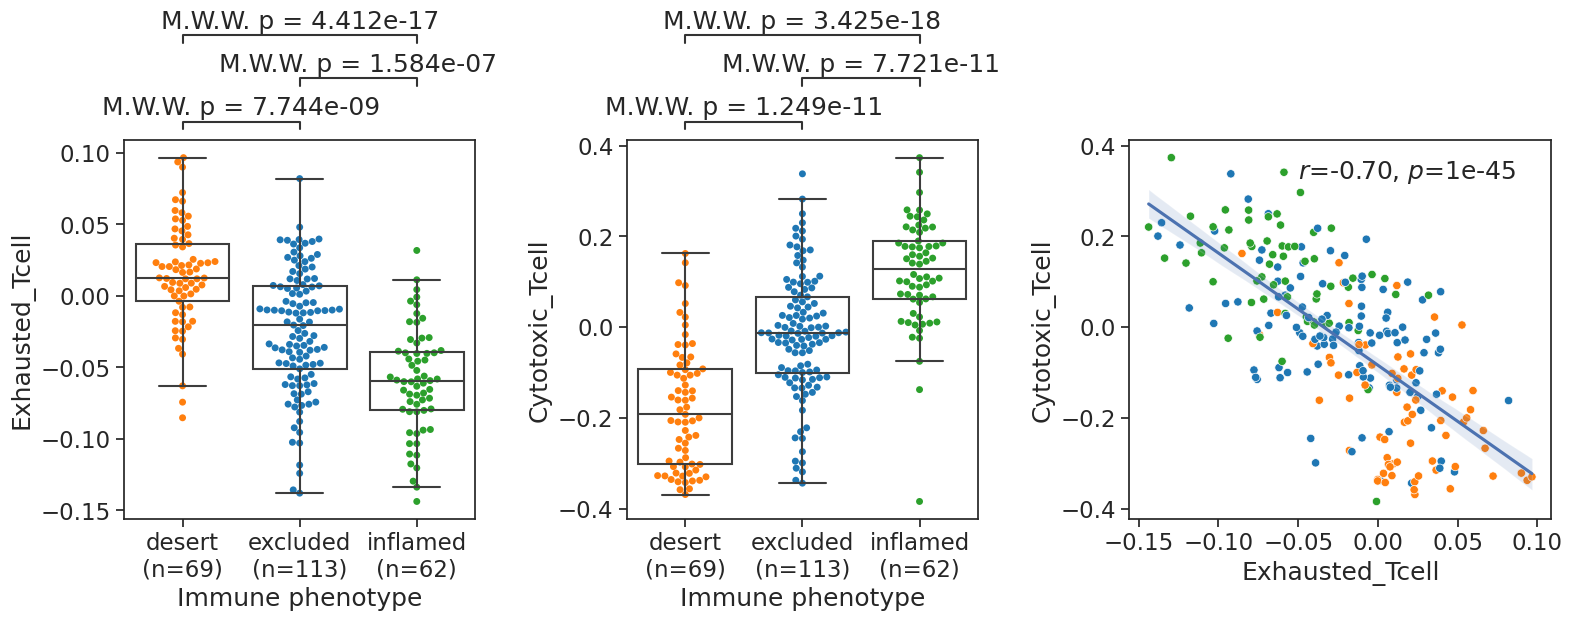

In [97]:
IMVigor210 = df_label[df_label.cohort == 'IMVigor210']

x = 'Immune phenotype'
y1 = 'Exhausted_Tcell'
y2 = 'Cytotoxic_Tcell'
x_order = ['desert', 'excluded', 'inflamed']
box_pairs = [('desert', 'excluded'), ('desert', 'inflamed'), ('excluded', 'inflamed')]
data = IMVigor210[[x]].join(dfcelltype[[y1,y2]])
size = data.groupby(x).size()
size = size.index + "\n(n=" + size.astype(str) + ')'
phenotype_map = size.to_dict()
data[x] = data[x].map(phenotype_map)
x_order = pd.Series(x_order).map(phenotype_map).tolist()

box_pairs = [(x_order[i], x_order[j]) for i in range(len(x_order)) for j in range(i+1, len(x_order))]



import scipy
from statannotations.Annotator import Annotator
def annotate(ax, data, x, y):
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x=data[x], y=data[y])
    ax.text(.4, .9, f'$r$={rvalue:.2f}, $p$={pvalue:.2g}', transform=ax.transAxes)
    

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 7), ncols=3, width_ratios = [1,1,1.2])

palette = sns.palettes.color_palette('tab10', 4)
palette = [palette[1], palette[0], palette[2]]


sns.boxplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})
sns.boxplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})

sns.swarmplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2,  palette = palette,  zorder=.5)

sns.swarmplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1,  palette = palette, zorder=.5)


annotator = Annotator(ax1, pairs=box_pairs, data=data, x=x, y=y1, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='full', loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()

annotator = Annotator(ax2, pairs=box_pairs, data=data, x=x, y=y2, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='full',  loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()


sns.scatterplot(data = data, x = y1, y = y2,  hue = x, ax=ax3, legend = False, 
                palette = palette, hue_order = x_order)
sns.regplot(data=data, x=y1, y=y2, scatter=False, ax=ax3)
annotate(ax3, data, y1, y2)

for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    # ax.set_xticklabels(
    #     x_order, 
    #     rotation=1, 
    #     ha="right",  
    #     rotation_mode="anchor")  # <====== HERE is the ke

ax3.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)

    
fig.tight_layout()

fig.savefig('IMvigor210_score_phenotype.pdf')

In [134]:
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

mp1 = PCA(n_components=2,)
dfc_2d1 = pd.DataFrame(mp1.fit_transform(dfc_feat), index = dfc_feat.index,  columns=['PCA1', 'PCA2'])
mp2 = UMAP(n_components=2, spread=1, min_dist=0.8, verbose=1)
dfc_2d2 = pd.DataFrame(mp2.fit_transform(dfc_feat), index = dfc_feat.index,  columns=['UMAP1', 'UMAP2'])

dfc_2d = dfc_2d1.join(dfc_2d2)
dfc_2d['celltype'] = dfc_2d.index.map(lambda x:x.split('$$')[1])
dfc_2d['sampleindex'] = dfc_2d.index.map(lambda x:x.split('$$')[0])
dfc_2d['cohort'] = dfc_2d['sampleindex'].map(df_label.cohort)
dfc_2d['cancer_type'] = dfc_2d['sampleindex'].map(df_label.cancer_type)
dfc_2d['response_label'] = dfc_2d['sampleindex'].map(df_label.response_label)
dfc_2d['Immune phenotype'] = dfc_2d['sampleindex'].map(df_label['Immune phenotype'])

UMAP(min_dist=0.8, spread=1, verbose=1)
Sat Mar  9 15:55:04 2024 Construct fuzzy simplicial set
Sat Mar  9 15:55:04 2024 Finding Nearest Neighbors
Sat Mar  9 15:55:04 2024 Building RP forest with 16 trees
Sat Mar  9 15:55:04 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Sat Mar  9 15:55:08 2024 Finished Nearest Neighbor Search
Sat Mar  9 15:55:09 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Mar  9 15:55:49 2024 Finished embedding


In [138]:
dfc_2d.shape

(50985, 10)

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

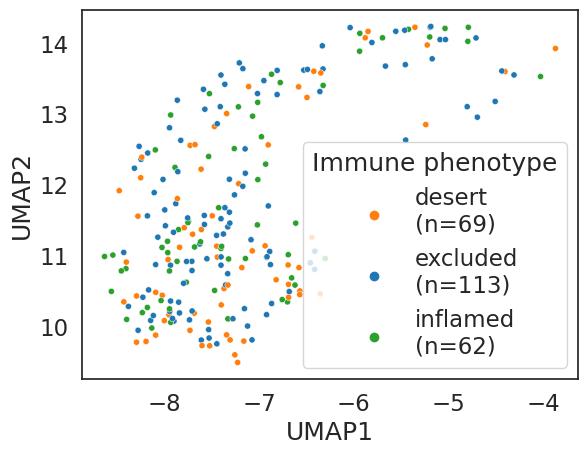

In [172]:
dfp = dfc_2d #dfc_2d[dfc_2d.cohort == 'IMVigor210']
dfp = dfp[dfp['celltype'].isin([y1])]
dfp[x] = dfp[x].map(size)

dfp = dfp[~dfp.index.isin(['IMVigor210-3ee5dc-ar-3ee5dcd$$Exhausted_Tcell'])]
sns.scatterplot(dfp, x = 'UMAP1', y = 'UMAP2', hue = x, s=20, hue_order = x_order, palette=palette)

In [169]:
dfp[dfp.UMAP1 > 5]

,PCA1,PCA2,UMAP1,UMAP2,celltype,sampleindex,cohort,cancer_type,response_label,Immune phenotype
IMVigor210-3ee5dc-ar-3ee5dcd$$Exhausted_Tcell,-0.571269,-0.055065,7.283160,1.095484,Exhausted_Tcell,IMVigor210-3ee5dc-ar-3ee5dcd,IMVigor210,BLCA,NR,desert\n(n=69)
NSCLC_Ravi_SU2CLC-CLE-NIVO24-T1$$Exhausted_Tcell,-0.368087,-0.096332,7.112758,1.085136,Exhausted_Tcell,NSCLC_Ravi_SU2CLC-CLE-NIVO24-T1,SU2CLC2,LUSC,NR,NaN
NSCLC_Ravi_SU2CLC-CLE-NIVO31-T1$$Exhausted_Tcell,-0.934015,-0.177859,7.382332,0.746622,Exhausted_Tcell,NSCLC_Ravi_SU2CLC-CLE-NIVO31-T1,SU2CLC2,LUSC,NR,NaN
NSCLC_Ravi_SU2CLC-MDA-1564-T1$$Exhausted_Tcell,-0.641281,-0.189361,7.370058,0.827958,Exhausted_Tcell,NSCLC_Ravi_SU2CLC-MDA-1564-T1,SU2CLC2,LUSC,NR,NaN
126T-Tumor-SM-CDZ2D$$Exhausted_Tcell,-0.798550,-0.185947,7.491086,0.778876,Exhausted_Tcell,126T-Tumor-SM-CDZ2D,MGH,SKCM,R,NaN
99T-Tumor-SM-AH3NB$$Exhausted_Tcell,1.924659,0.791956,13.813735,18.039635,Exhausted_Tcell,99T-Tumor-SM-AH3NB,MGH,SKCM,R,NaN


<Axes: xlabel='PCA1', ylabel='PCA2'>

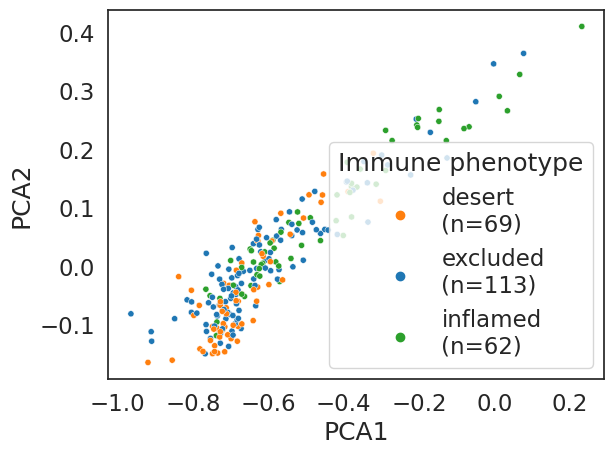

In [153]:
dfp = dfc_2d #[dfc_2d.cohort == 'IMVigor210']
dfp = dfp[dfp['celltype'].isin([y2])]
dfp[x] = dfp[x].map(size)
sns.scatterplot(dfp, x = 'PCA1', y = 'PCA2', hue = x, s=20, hue_order = x_order, palette=palette)

In [159]:
dfp.celltype.unique()

array(['Exhausted_Tcell'], dtype=object)

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

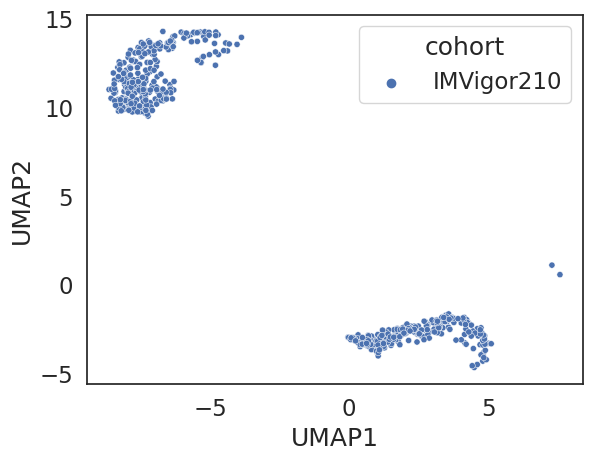

In [166]:
dfp = dfc_2d[dfc_2d.cohort == 'IMVigor210'] 
dfp = dfp[dfp.celltype.isin([y1,y2])] 

sns.scatterplot(dfp, x = 'UMAP1', y = 'UMAP2', hue = 'cohort', s=20, )

In [157]:
dfc_2d

,PCA1,PCA2,UMAP1,UMAP2,celltype,sampleindex,cohort,cancer_type,response_label,Immune phenotype
IMVigor210-0257bb-ar-0257bbb$$Cytotoxic_Tcell,-0.804466,-0.078661,1.265644,-3.563584,Cytotoxic_Tcell,IMVigor210-0257bb-ar-0257bbb,IMVigor210,BLCA,NR,excluded\n(n=113)
IMVigor210-025b45-ar-025b45c$$Cytotoxic_Tcell,-0.798054,-0.083881,1.002135,-3.557684,Cytotoxic_Tcell,IMVigor210-025b45-ar-025b45c,IMVigor210,BLCA,NR,desert\n(n=69)
IMVigor210-032c64-ar-032c642$$Cytotoxic_Tcell,-0.066939,0.238420,4.993251,-3.306777,Cytotoxic_Tcell,IMVigor210-032c64-ar-032c642,IMVigor210,BLCA,NR,inflamed\n(n=62)
IMVigor210-0571f1-ar-0571f17$$Cytotoxic_Tcell,-0.001660,0.346037,4.829155,-3.825601,Cytotoxic_Tcell,IMVigor210-0571f1-ar-0571f17,IMVigor210,BLCA,NR,excluded\n(n=113)
IMVigor210-065890-ar-0658907$$Cytotoxic_Tcell,-0.646209,-0.032995,1.629589,-2.819331,Cytotoxic_Tcell,IMVigor210-065890-ar-0658907,IMVigor210,BLCA,R,inflamed\n(n=62)
...,...,...,...,...,...,...,...,...,...,...
Kim_NatMed_2018-p664-ar-026$$Cytotoxic_Tcell,-0.914960,-0.003818,1.960781,-4.312118,Cytotoxic_Tcell,Kim_NatMed_2018-p664-ar-026,Kim,STAD,NR,NaN
Kim_NatMed_2018-p666-ar-029$$Cytotoxic_Tcell,-1.088508,-0.102090,1.442760,-4.342272,Cytotoxic_Tcell,Kim_NatMed_2018-p666-ar-029,Kim,STAD,NR,NaN
Kim_NatMed_2018-p667-ar-030$$Cytotoxic_Tcell,-1.069147,-0.071681,1.551376,-4.335926,Cytotoxic_Tcell,Kim_NatMed_2018-p667-ar-030,Kim,STAD,NR,NaN
Kim_NatMed_2018-p668-ar-031$$Cytotoxic_Tcell,-0.730226,0.096741,2.222831,-3.605380,Cytotoxic_Tcell,Kim_NatMed_2018-p668-ar-031,Kim,STAD,R,NaN
